[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/casangi/sirius/blob/main/docs/alma_single_field.ipynb)

# Single Field ALMA Simulation

ALMA simulation setup:
- Single field (phase center: ra=19h59m28.5s,dec=-40d44m51.5s)
- Single point source (1 Jy, ra=19h59m28.5s,dec=-40d44m51.5s)
- Frequencies
- Time (180 time samples)




## Install SiRIUS and Import Packages

In [1]:
import os
try:
    import sirius 
    print('SiRIUS version',sirius.__version__,'already installed.')
except ImportError as e:
    print(e)
    print('Installing SiRIUS')
    os.system("pip install sirius")
    import sirius 
    print('SiRIUS version',sirius.__version__,' installed.')

SiRIUS version 0.0.28 already installed.


In [2]:
import pkg_resources
import xarray as xr
import numpy as np
from sirius_data import _constants as cnt
from astropy import units as u
from astropy.coordinates import SkyCoord
from sirius.dio import make_time_xda, make_chan_xda 
from sirius_data.beam_1d_func_models.airy_disk import aca, alma
from sirius._sirius_utils._coord_transforms import _sin_pixel_to_celestial_coord
from sirius.display_tools import display_image
from casatasks import tclean

xr.set_options(display_style="html")
import os
try:
    from google.colab import output
    output.enable_custom_widget_manager()
    IN_COLAB = True
    %matplotlib widget 
except:
    IN_COLAB = False
    %matplotlib inline

# If using uvw_parms['calc_method'] = 'casa' .casarc must have directory of casadata. 
import pkg_resources
casa_data_dir = pkg_resources.resource_filename('casadata', '__data__')
rc_file = open(os.path.expanduser("~/.casarc"), "a+")  # append mode
rc_file.write("\n measures.directory: " + casa_data_dir)
rc_file.close()

alma['func'] = 'airy'
alma['dish_diam'] = 10.0
print(alma)

print('complete')

{'func': 'airy', 'dish_diam': 10.0, 'blockage_diam': 0.75, 'max_rad_1GHz': 0.03113667385557884}
complete


## Setup Simulation

In [3]:
# Image Parameters
#working_dir = '/lustre/cv/users/jsteeb/simulation/'
working_dir = ''
image_size = np.array([1024,1024])
#cell_size = np.array([-0.3,0.3]) 
cell_size = np.array([-0.15,0.15]) 
cell = np.array([str(-cell_size[0]) + 'arcsec',str(cell_size[1]) + 'arcsec']) #Used in tclean command
cell_size = cell_size*cnt.arcsec_to_rad 

# Get telescope layout 
tel_dir = pkg_resources.resource_filename('sirius_data', 'telescope_layout/data/alma.all.tel.zarr')
tel_xds = xr.open_zarr(tel_dir,consolidated=False)
dish_diameter = 12.0
tel_xds = tel_xds.where(tel_xds.DISH_DIAMETER == dish_diameter,drop=True) #Only select 12m dishes

# Time and Frequency Axis
time_xda = make_time_xda(time_start='2020-10-03T18:57:28.95',time_delta=2000,n_samples=180,n_chunks=1)
chan_xda = make_chan_xda(spw_name = 'Band3',freq_start = 90*10**9, freq_delta = 2*10**9, freq_resolution=1*10**6, n_channels=5, n_chunks=1)

# Beam model
beam_models = [alma]
beam_model_map = tel_xds.DISH_DIAMETER.values  
beam_model_map[beam_model_map == dish_diameter] = 0
beam_model_map= beam_model_map.astype(int) # beam_model_map maps the antenna index to a model in beam_models.
beam_parms = {} #Use default beam parms.

# Polarizations
pol = [9,12] # ['RR','RL','LR','LL'] => [5,6,7,8], ['XX','XY','YX','YY'] => [9,10,11,12]

# UVW parameters
uvw_parms = {} # use defaults

# Setup Field
phase_center_skycoord = SkyCoord(ra='19h59m28.5s',dec='-40d44m51.5s',frame='fk5')
phase_center_ra_dec = np.array([phase_center_skycoord.ra.rad,phase_center_skycoord.dec.rad])[None,:] #[n_time, 2] (singleton: n_time)
phase_center_names = np.array(['field1']) #[n_time] (singleton: n_time)

# Setup Point Source
pixel = np.array([512,612])[None,:] # The source will be positioned at the center of a pixel.
point_source_ra_dec = _sin_pixel_to_celestial_coord(phase_center_ra_dec[0,:],image_size,cell_size,pixel)[None,:,:] #[n_time, n_point_sources, 2] (singleton: n_time)
point_source_skycoord = SkyCoord(ra=point_source_ra_dec[0,0,0]*u.rad,dec=point_source_ra_dec[0,0,1]*u.rad,frame='fk5') 
print('The position of the source is ', point_source_skycoord.ra.hms,point_source_skycoord.dec.dms)
point_source_flux = np.array([1.0, 0, 0, 1.0])[None,None,None,:]  #[n_point_sources, n_time, n_chan, n_pol] (singleton: n_time, n_chan)

# Pointing Offsets
pointing_ra_dec = None #No pointing offsets

# Noise parameters
noise_parms = None



Number of chunks  1
Number of chunks  1
The position of the source is  hms_tuple(h=19.0, m=59.0, s=28.50000000000307) dms_tuple(d=-40.0, m=-44.0, s=-36.49999998675412)


## Run Simulation

In [4]:
from sirius import simulation
save_parms = {'ms_name':working_dir+'alma_sim.ms','write_to_ms':True}
vis_xds = simulation(point_source_flux, 
                     point_source_ra_dec, 
                     pointing_ra_dec, 
                     phase_center_ra_dec, 
                     phase_center_names, 
                     beam_parms,beam_models,
                     beam_model_map,uvw_parms, 
                     tel_xds, time_xda, chan_xda, pol, noise_parms, save_parms) 
vis_xds

Setting default calc_method  to  astropy
Setting default auto_corr  to  False
Setting default fov_scaling  to  4.0
Setting default mueller_selection  to  [ 0  5 10 15]
Setting default zernike_freq_interp  to  nearest
Setting default pa_radius  to  0.2
Setting default image_size  to  [1000 1000]
Setting default mode  to  dask_ms_and_sim_tool
Setting default DAG_name_vis_uvw_gen  to  False
Setting default DAG_name_write  to  False
180 15225 5 2
<xarray.Dataset>
Dimensions:  (time: 180, pol: 2, chan: 5, baseline: 15225, uvw: 3,
              time_chunk: 1, chan_chunk: 1, 4: 4)
Coordinates:
  * time     (time) <U23 '2020-10-03T18:57:28.950' ... '2020-10-07T22:24:08.950'
  * pol      (pol) int64 9 12
  * chan     (chan) float64 9e+10 9.2e+10 9.4e+10 9.6e+10 9.8e+10
Dimensions without coordinates: baseline, uvw, time_chunk, chan_chunk, 4
Data variables:
    DATA     (time, baseline, chan, pol) complex128 dask.array<chunksize=(180, 15225, 5, 2), meta=np.ndarray>
    UVW      (time, baseline, 

<xarray.Dataset>
Dimensions:           (polarization_ids: 1, spw_ids: 1)
Coordinates:
  * polarization_ids  (polarization_ids) int64 0
  * spw_ids           (spw_ids) int64 0
Data variables:
    *empty*
Attributes:
    xds0:              <xarray.Dataset>\nDimensions:         (row: 2740500, u...
    SPECTRAL_WINDOW:   <xarray.Dataset>\nDimensions:          (row: 1, d1: 5)...
    POLARIZATION:      <xarray.Dataset>\nDimensions:       (row: 1, d1: 2, d2...
    DATA_DESCRIPTION:  <xarray.Dataset>\nDimensions:             (row: 1)\nCo...

## Imaging niter = 0

In [5]:
image_name = working_dir+'im_alma_sim'
os.system('rm -rf '+image_name+'_niter0_*')

tclean(vis=save_parms['ms_name'],imagename=image_name+'_niter0_std',imsize=image_size,cell=cell,specmode='cube',niter=0,pblimit=0.2,pbmask=0.2,gridder='standard',stokes='XX',weighting='natural',datacolumn='data')

tclean(vis=save_parms['ms_name'],imagename=image_name+'_niter0_m',imsize=image_size,cell=cell,specmode='cube',niter=0,pblimit=0.2,pbmask=0.2,gridder='mosaic',stokes='XX',weighting='natural',datacolumn='data')


0%....10....20....30....40....50....60....70....80....90....100%

0%....10....20....30....40....50....60....70....80....90....100%
2022-03-16 17:23:19	WARN	task_tclean::SIImageStore::restore (file src/code/synthesis/ImagerObjects/SIImageStore.cc, line 2246)	Restoring with an empty model image. Only residuals will be processed to form the output restored image.
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
OMP: Info #276: omp_set_nested routine deprecated, ple

{}

Abs of visibility for channel  0 : 0.8873939
####################################################################################################
Peak Intensity (chan0) : 0.8873690
PB at location of Intensity peak (chan0) : 0.8815771
max pixel location  (array([512]), array([612]), array([0]), array([0]))
Residual RMS : 0.0100675


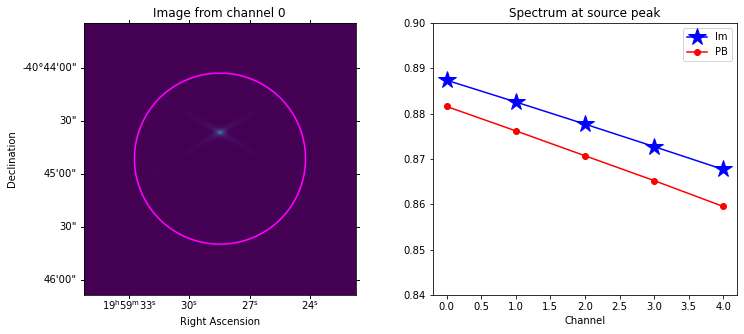

####################################################################################################
Peak Intensity (chan0) : 0.8827165
PB at location of Intensity peak (chan0) : 0.8737198
max pixel location  (array([512]), array([612]), array([0]), array([0]))
Residual RMS : 0.0100281


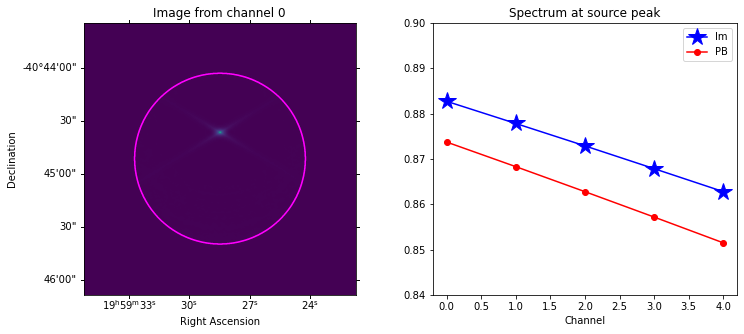

(0.8827165365219116, 0.01002805296120395)

In [7]:
chan=0
print('Abs of visibility for channel ' , chan , ':', abs(np.abs(vis_xds.xds0.DATA[0,chan,0].values)))
print('#'*100)
display_image(imname=image_name+'_niter0_std.image',pbname=image_name+'_niter0_std.pb',resname=image_name+'_niter0_std.residual',ylim=[0.84,0.9],chan=chan)
print('#'*100)
display_image(imname=image_name+'_niter0_m.image',pbname=image_name+'_niter0_m.pb',resname=image_name+'_niter0_m.residual',ylim=[0.84,0.9],chan=chan)


## Imaging niter = 1000

In [8]:
niter = 1000
os.system('rm -rf '+image_name+'_niter'+str(niter)+'_*')
tclean(vis=save_parms['ms_name'],imagename=image_name+'_niter'+str(niter)+'_std',imsize=image_size,cell=cell,specmode='cube',niter=niter,pblimit=0.2,pbmask=0.2,gridder='standard',stokes='XX',weighting='natural',datacolumn='data')

tclean(vis=save_parms['ms_name'],imagename=image_name+'_niter'+str(niter)+'_m',imsize=image_size,cell=cell,specmode='cube',niter=niter,pblimit=0.2,pbmask=0.2,gridder='mosaic',stokes='XX',weighting='natural',datacolumn='data')


0%....10....20....30....40....50....60....70....80....90....100%

0%....10....20....30....40....50....60....70....80....90....100%

0%....10....20....30....40....50....60....70....80....90....100%

0%....10....20....30....40....50....60....70....80....90....100%

0%....10....20....30....40....50....60....70....80....90....100%

0%....10....20....30....40....50....60....70....80....90....100%

0%....10....20....30....40....50....60....70....80....90....100%

0%....10....20....30....40....50....60....70....80....90....100%

0%....10....20....30....40....50....60....70....80....90....100%
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
OMP: Info #276: om

{}

Abs of visibility for channel  0 : 0.8873939
####################################################################################################
Peak Intensity (chan0) : 0.8874448
PB at location of Intensity peak (chan0) : 0.8815771
max pixel location  (array([512]), array([612]), array([0]), array([0]))
Residual RMS : 0.0000041


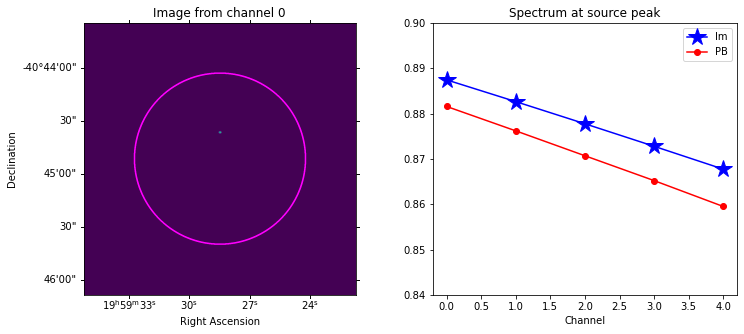

####################################################################################################
Peak Intensity (chan0) : 0.8915214
PB at location of Intensity peak (chan0) : 0.8737198
max pixel location  (array([512]), array([612]), array([0]), array([0]))
Residual RMS : 0.0000291


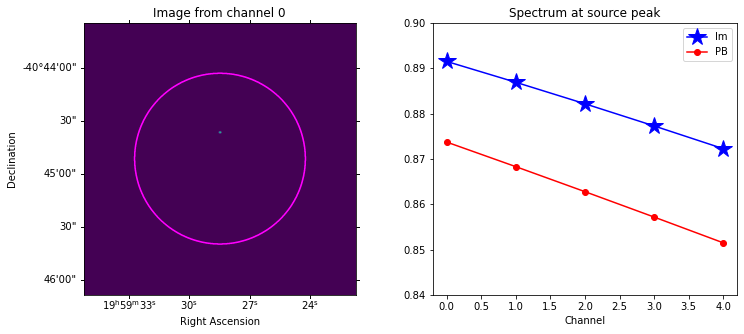

(0.8915213942527771, 2.9058321458074734e-05)

In [9]:
chan=0
print('Abs of visibility for channel ' , chan , ':', abs(np.abs(vis_xds.xds0.DATA[0,chan,0].values)))
print('#'*100)
display_image(imname=image_name+'_niter'+str(niter)+'_std.image',pbname=image_name+'_niter'+str(niter)+'_std.pb',resname=image_name+'_niter'+str(niter)+'_std.residual',ylim=[0.84,0.9],chan=chan)
print('#'*100)
display_image(imname=image_name+'_niter'+str(niter)+'_m.image',pbname=image_name+'_niter'+str(niter)+'_m.pb',resname=image_name+'_niter'+str(niter)+'_m.residual',ylim=[0.84,0.9],chan=chan)

## Increase number of Sources

In [10]:
# Setup Point Source
pixel = np.array([[512,612],[512,512],[650,650],[450,473]]) 
point_source_ra_dec = _sin_pixel_to_celestial_coord(phase_center_ra_dec[0,:],image_size,cell_size,pixel)[None,:,:] #[n_time, n_point_sources, 2] (singleton: n_time)
point_source_skycoord = SkyCoord(ra=point_source_ra_dec[0,0,0]*u.rad,dec=point_source_ra_dec[0,0,1]*u.rad,frame='fk5') 
print('The position of the source is ', point_source_skycoord.ra.hms,point_source_skycoord.dec.dms)
point_source_flux = np.array([[1.0, 0, 0, 1.0],[0.5, 0, 0, 0.5],[0.65, 0, 0, 0.65],[0.34, 0, 0, 0.34]])[:,None,None,:]  #[n_point_sources, n_time, n_chan, n_pol] (singleton: n_time, n_chan)

from sirius import simulation
save_parms = {'ms_name':working_dir+'msource_alma_sim.ms','write_to_ms':True}
vis_xds = simulation(point_source_flux, 
                     point_source_ra_dec, 
                     pointing_ra_dec, 
                     phase_center_ra_dec, 
                     phase_center_names, 
                     beam_parms,beam_models,
                     beam_model_map,uvw_parms, 
                     tel_xds, time_xda, chan_xda, pol, noise_parms, save_parms) 
vis_xds


The position of the source is  hms_tuple(h=19.0, m=59.0, s=28.50000000000307) dms_tuple(d=-40.0, m=-44.0, s=-36.49999998675412)
Setting default calc_method  to  astropy
Setting default auto_corr  to  False
Setting default fov_scaling  to  4.0
Setting default mueller_selection  to  [ 0  5 10 15]
Setting default zernike_freq_interp  to  nearest
Setting default pa_radius  to  0.2
Setting default image_size  to  [1000 1000]
Setting default mode  to  dask_ms_and_sim_tool
Setting default DAG_name_vis_uvw_gen  to  False
Setting default DAG_name_write  to  False
180 15225 5 2
<xarray.Dataset>
Dimensions:  (time: 180, pol: 2, chan: 5, baseline: 15225, uvw: 3,
              time_chunk: 1, chan_chunk: 1, 4: 4)
Coordinates:
  * time     (time) <U23 '2020-10-03T18:57:28.950' ... '2020-10-07T22:24:08.950'
  * pol      (pol) int64 9 12
  * chan     (chan) float64 9e+10 9.2e+10 9.4e+10 9.6e+10 9.8e+10
Dimensions without coordinates: baseline, uvw, time_chunk, chan_chunk, 4
Data variables:
    DATA    

<xarray.Dataset>
Dimensions:           (polarization_ids: 1, spw_ids: 1)
Coordinates:
  * polarization_ids  (polarization_ids) int64 0
  * spw_ids           (spw_ids) int64 0
Data variables:
    *empty*
Attributes:
    xds0:              <xarray.Dataset>\nDimensions:         (row: 2740500, u...
    SPECTRAL_WINDOW:   <xarray.Dataset>\nDimensions:          (row: 1, d1: 5)...
    POLARIZATION:      <xarray.Dataset>\nDimensions:       (row: 1, d1: 2, d2...
    DATA_DESCRIPTION:  <xarray.Dataset>\nDimensions:             (row: 1)\nCo...

In [11]:
image_name = working_dir+'im_alma_sim'
os.system('rm -rf '+image_name+'_niter0_*')

tclean(vis=save_parms['ms_name'],imagename=image_name+'_niter0_std',imsize=image_size,cell=cell,specmode='cube',niter=0,pblimit=0.2,pbmask=0.2,gridder='standard',stokes='XX',weighting='natural',datacolumn='data')

tclean(vis=save_parms['ms_name'],imagename=image_name+'_niter0_m',imsize=image_size,cell=cell,specmode='cube',niter=0,pblimit=0.2,pbmask=0.2,gridder='mosaic',stokes='XX',weighting='natural',datacolumn='data')


0%....10....20....30....40....50....60....70....80....90....100%

0%....10....20....30....40....50....60....70....80....90....100%
2022-03-16 17:42:27	WARN	task_tclean::SIImageStore::restore (file src/code/synthesis/ImagerObjects/SIImageStore.cc, line 2246)	Restoring with an empty model image. Only residuals will be processed to form the output restored image.
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
OMP: Info #276: omp_set_nested routine deprecated, ple

{}

Abs of visibility for channel  0 : 1.3650753
####################################################################################################
Peak Intensity (chan0) : 0.8849095
PB at location of Intensity peak (chan0) : 0.8815771
max pixel location  (array([512]), array([612]), array([0]), array([0]))
Residual RMS : 0.0128337


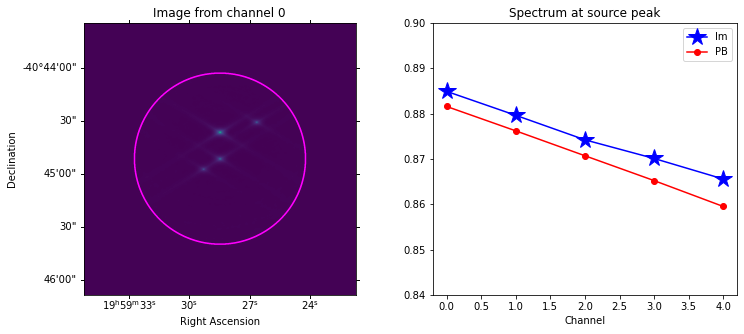

####################################################################################################
Peak Intensity (chan0) : 0.8803405
PB at location of Intensity peak (chan0) : 0.8737198
max pixel location  (array([512]), array([612]), array([0]), array([0]))
Residual RMS : 0.0127897


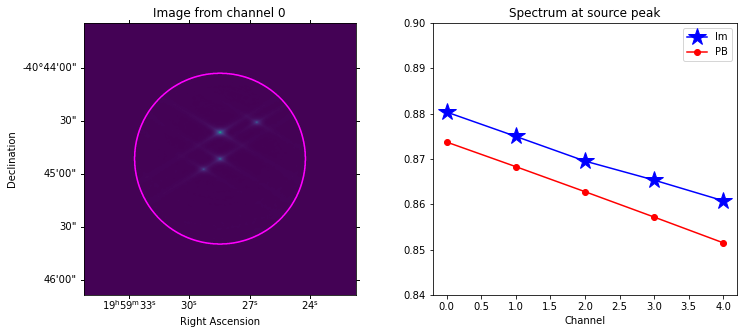

(0.8803405165672302, 0.012789708181056035)

In [12]:
chan=0
print('Abs of visibility for channel ' , chan , ':', abs(np.abs(vis_xds.xds0.DATA[0,chan,0].values)))
print('#'*100)
display_image(imname=image_name+'_niter0_std.image',pbname=image_name+'_niter0_std.pb',resname=image_name+'_niter0_std.residual',ylim=[0.84,0.9],chan=chan)
print('#'*100)
display_image(imname=image_name+'_niter0_m.image',pbname=image_name+'_niter0_m.pb',resname=image_name+'_niter0_m.residual',ylim=[0.84,0.9],chan=chan)

In [13]:
niter = 1000
os.system('rm -rf '+image_name+'_niter'+str(niter)+'_*')
tclean(vis=save_parms['ms_name'],imagename=image_name+'_niter'+str(niter)+'_std',imsize=image_size,cell=cell,specmode='cube',niter=niter,pblimit=0.2,pbmask=0.2,gridder='standard',stokes='XX',weighting='natural',datacolumn='data')

tclean(vis=save_parms['ms_name'],imagename=image_name+'_niter'+str(niter)+'_m',imsize=image_size,cell=cell,specmode='cube',niter=niter,pblimit=0.2,pbmask=0.2,gridder='mosaic',stokes='XX',weighting='natural',datacolumn='data')


0%....10....20....30....40....50....60....70....80....90....100%

0%....10....20....30....40....50....60....70....80....90....100%

0%....10....20....30....40....50....60....70....80....90....100%

0%....10....20....30....40....50....60....70....80....90....100%

0%....10....20....30....40....50....60....70....80....90....100%

0%....10....20....30....40....50....60....70....80....90....100%
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
OMP: Info #276: omp_se

{}

Abs of visibility for channel  0 : 1.3650753
####################################################################################################
Peak Intensity (chan0) : 0.8874919
PB at location of Intensity peak (chan0) : 0.8815771
max pixel location  (array([512]), array([612]), array([0]), array([0]))
Residual RMS : 0.0000202


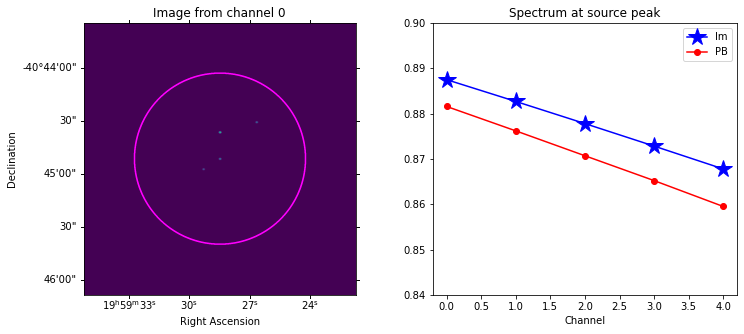

####################################################################################################
Peak Intensity (chan0) : 0.8917176
PB at location of Intensity peak (chan0) : 0.8737198
max pixel location  (array([512]), array([612]), array([0]), array([0]))
Residual RMS : 0.0000386


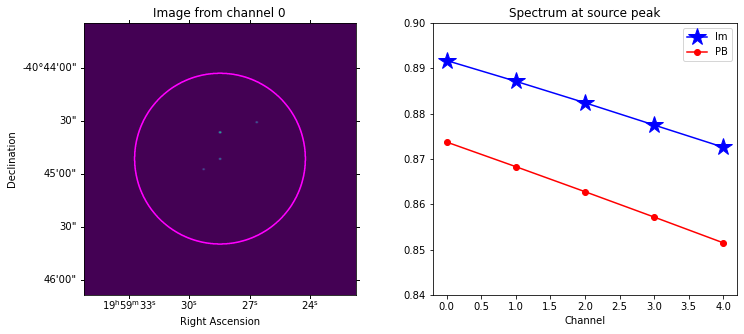

(0.8917175531387329, 3.856849138287457e-05)

In [14]:
chan=0
#niter=1000
print('Abs of visibility for channel ' , chan , ':', abs(np.abs(vis_xds.xds0.DATA[0,chan,0].values)))
print('#'*100)
display_image(imname=image_name+'_niter'+str(niter)+'_std.image',pbname=image_name+'_niter'+str(niter)+'_std.pb',resname=image_name+'_niter'+str(niter)+'_std.residual',ylim=[0.84,0.9],chan=chan)
print('#'*100)
display_image(imname=image_name+'_niter'+str(niter)+'_m.image',pbname=image_name+'_niter'+str(niter)+'_m.pb',resname=image_name+'_niter'+str(niter)+'_m.residual',ylim=[0.84,0.9],chan=chan)